<center><h3><b><u> Multilayer Perceptron with MNIST Dataset</u></b></h1></center>

#### __Importing Libraries, Classes, and Functions__

In [143]:
import operator #itemgetter
import torch
import torch.nn as nn #provides classes/modules for making neural networks
from torch.nn import Linear
import torch.nn.functional as F #a module with common nn functions (operations on tensors/high dim matrices; activations)
import torch.optim as optim #contains optimization algorithms like SGD
from torchvision import datasets, transforms #includes MNIST, transform images -> tensors
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split #allows shuffling and minbatches
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

#### __The Model Blueprint__

In [98]:
'''Can use GPU, which has lots of cores, instead if available. It is good for parallel processing for tasks
like matrix multiplication where job can be split up to calculate each element of new matrix. GPU's also have
high bandwidth so they can indirectly have faster time talking to memory. This computer doesn't have cuda so
run on CoLab.
'''
#Create a NN class that encapsulates all components of NN, instantiate later
# with __call__ object name can be treated as function that calls certain function in class (predefine)
#inherits from nn.Module class; many classes for different layers
class NumberNN(nn.Module): 
    def __init__(self):
        super(NumberNN, self).__init__() #explicitly call parent class constructor to initialize stuff
                                    #parent technically initialized too and tied to child but you only access child
        self.fc1 = Linear(in_features = 28**2, out_features = 128) #first fully connected layer has 784 input neurons
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64, 10)
    
    def forward(self, pixels):
        '''MNIST is (batch_size = ..., channels = 1, height = 28, width = 28)
        Fully connected layers expect input tensors to be (batch_size, num_features); labels already liked this
        Size of first dimension of tensor is batch size, -1 infers dim of the vector/features (784)
        '''
        pixels = pixels.view(-1, 28**2)  # Flatten the input tensor (batch_size, 1, 28, 28) to (batch_size, 784)
        
        pixels = F.leaky_relu(self.fc1(pixels), negative_slope= 0.02)
        pixels = F.leaky_relu(self.fc2(pixels), negative_slope= 0.02) 
        pixels = self.fc3(pixels) # Output layer (logits)
        return pixels
    
#Instantiate model
model = NumberNN()

#Loss function - making instance of this class to use the functions in it
cross_entropy = nn.CrossEntropyLoss()

#Other optimizers than SGD like Adam, takes momentum into account for adaptive learning rate: .05 good for SGD
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

'''transformation function object: applies transformations in list sequentially; images into tensors -> normalize
normalize transforms the pixel values more condensed/similar so training is faster
Normalizing for single channel (good practice to include tuple instead of scalar even if only one channel)'''
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#Load MNIST
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)

#creates iterator that provides batches of data during training
#the batches are in form of (image, label) tuple which are just tensors/vectors
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

#Adds batch size to image tensor in train loader
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

#### __Training the Model__

In [99]:
'''Each parameter has its own special tensor (created per layer) 
with a number for its partial derivative in .grad attribute of tensor; step() accesses these'''

def train_model(model, train_loader, optimizer, loss, num_epochs):
    #Hyperparameter
    num_epochs = 5

    for epoch in range(num_epochs): #will do training cycle 5 times

        #each iteration is one minibatch of images/labels
        for images, labels in train_loader: 
            optimizer.zero_grad() #zeroing out gradient ignores .grad and recalculates partials in backprop
            outputs = model(images) #passes this to forward

            #numclasses is components; ex. 4 = [0,0,0,1,0,0,...]
            target = F.one_hot(labels, num_classes=10).float()

            loss = cross_entropy(outputs, target)
            loss.backward() #backward propogation to compute gradiaent
            optimizer.step() #updates model parameters (takes "step")

        #single number tensors converted to normal number with .item(); 4 decimal places as floating point number
        print(f'Epoch {epoch + 1}, Loss: {loss.item(): .4f}')

train_model(model, train_loader, optimizer, loss = cross_entropy, num_epochs = 5)

Epoch 1, Loss:  0.2767
Epoch 2, Loss:  0.1557
Epoch 3, Loss:  0.1065
Epoch 4, Loss:  0.2222
Epoch 5, Loss:  0.0083


#### __Saving the Model__

In [ ]:
#Saves these parameters in Colab or locally
'''Saves the parameters in colab. Model has state dictionary, a Python dictionary that maps to the weights and 
biases. Extracts this and stores it in a file with .pth convention by convention to store PyTorch parameters 
or entire models.'''
torch.save(model.state_dict(), 'bestmodel.pth')

In [ ]:
#Download locally
files.download('bestmodel.pth')

In [ ]:
#Move to correct folder if Colab used
model_downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "bestmodel.pth")

model_destination_path = "/mnt/c/Users/daria/OneDrive/Practice/nnPractice/bestmodel.pth"

shutil.move(model_downloads_path, model_destination_path)

#### __Loading the Saved Model__

In [100]:
def load_model():
    # Instantiate the model
    model = NumberNN()
    
    #Update model's parameters to what it was after training
    model.load_state_dict(torch.load('bestmodel.pth'))
    
    '''Sometimes in training some neurons turned off (called dropout) to prevent overfitting, but when testing 
you want all neurons in model to be used, so eval fixes this as well as other settings for testing so model
acts "normally"'''
    model.eval()
    
    return model

model = load_model()

#### __Evalulating/Testing the Model__

In [101]:
'''with - disable gradient discent for the for loop and enable when for loop ends
Don't store unnecessary numbers (eg. intermediate activations) for calculating gradient; 
Saves memory and its faster
'''

def test_model(model, test_loader):
    model.eval()

    #Counters
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)

            #Return two tensors for max values (brightest neurons) and their indices
            '''
            outputs dimensions: (batch_size, num_classes). Num_classes has value of each neuron in output
            layer. You have 1 array per training example, and for each mini-batch you have 2D array
            max has 2 outputs): the max values in each row and the indices of the max values
            We only care about index/number it predicted, so convention to store unimportant stuff in _
            1 as parameter input means find max along dimension 1
            '''
            _, predicted = torch.max(outputs, 1)

            #Update Counters
            total += labels.size(0) #size of first dimension (batch size)

            #Compare each tensor, which returns new tensor with each component being True or False
            #Sum counts the amount of True in the tensor
            correct += (predicted == labels).sum().item()
        return (correct/total) * 100

accuracy = test_model(model, test_loader)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 96.7


#### __Inputting a New Image__

In [135]:
def pixelate_image(image, pixelation_level):
    
    '''/ is floor division. Tuples have indices. Resize is changing # of pixels after knowing new 
    size of image, what makes it appear pixelated is then enlarging image so the few pixels are larger.
    Bilinear interpoloation is to get value of each pixel, look at weighted average of 4 nearest pixels 
    of where it would go to determine new value. Weighted based on what is closest to it. Then split those 
    big pixels up again so the size is same as original but looks more pixelated.'''

    new_size = (image.size[0] // pixelation_level, image.size[1] // pixelation_level)
    pixelated = image.resize(new_size,resample=Image.BILINEAR)

    pixelated = pixelated.resize((28, 28))
    
    return pixelated

#Preprocess using functions of the Image class
def preprocess_image(image_path):
    image = pixelate_image(image_path, 8)
    image = transform(image)  #Make it a tensor then normalize
    image = image.unsqueeze(0)  #Add another dimension (batch_size) to image; not used, but specific shape necessary
    return image

# Load and preprocess the image 
image = Image.open("6.1.png").convert('L') #"instantiating", gives size as attribute in tuple

pixelated_image_visual = pixelate_image(image, 5)

image_transformed = preprocess_image(image)


# Disable gradient computation for speedup
with torch.no_grad():
    output = model(image_transformed)
    _, predicted = torch.max(output, dim = 1)
    probabilities = F.softmax(output, dim = 1) #probabilities[i] that contains softmax for outputs of i+1 image 

#(number, probability tensor)
prob_tuples = list(enumerate(probabilities[0])) 

#to sort by max, extract probability with itemgetter
prob_tuples.sort(key = itemgetter(1), reverse = True)

for number, probability in prob_tuples:
    print(f'Probability of {number}: {probability.item() * 100: .2f}%')

print(f'\nPredicted number: {predicted.item()}')

Probability of 6:  99.91%
Probability of 4:  0.05%
Probability of 8:  0.03%
Probability of 5:  0.01%
Probability of 0:  0.00%
Probability of 2:  0.00%
Probability of 9:  0.00%
Probability of 7:  0.00%
Probability of 3:  0.00%
Probability of 1:  0.00%

Predicted number: 6


#### __Visualizing the Transformed Image__

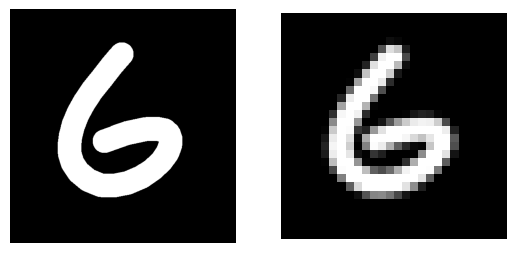

In [136]:
plt.subplot(1,2,1) #create subplot first
plt.imshow(image, cmap='gray')
plt.axis('off')

#dimensions need to be correct
plt.subplot(1,2,2)
plt.imshow(pixelated_image_visual, cmap='gray')
plt.axis('off') 

plt.show() #not needed for Jupyter